In [1]:
import matplotlib.pyplot as plt

import nengo
from nengo.processes import Piecewise

In [2]:
tau = 0.1  # Post-synaptic time constant for feedback
w_max = 10  # Maximum frequency in Hz is w_max/(2*pi)

model = nengo.Network(label="Controlled Oscillator")
with model:
    # The ensemble for the oscillator
    oscillator = nengo.Ensemble(500, dimensions=3, radius=1.7)

    # The feedback connection
    def feedback(x):
        x0, x1, w = x  # These are the three variables stored in the ensemble
        return x0 - w * w_max * tau * x1, x1 + w * w_max * tau * x0, 0

    nengo.Connection(oscillator, oscillator, function=feedback, synapse=tau)

    # The ensemble for controlling the speed of oscillation
    frequency = nengo.Ensemble(100, dimensions=1)

    nengo.Connection(frequency, oscillator[2])

In [3]:
with model:
    # We need a quick input at the beginning to start the oscillator
    initial = nengo.Node(Piecewise({0: [1, 0, 0], 0.15: [0, 0, 0]}))
    nengo.Connection(initial, oscillator)

    # Vary the speed over time
    input_frequency = nengo.Node(Piecewise({0: 1, 1: 0.5, 2: 0, 3: -0.5, 4: -1}))

    nengo.Connection(input_frequency, frequency)

In [7]:
with model:
    # Indicate which values to record
    oscillator_probe = nengo.Probe(oscillator, synapse=0.06)

In [8]:
with nengo.Simulator(model) as sim:
    sim.run(5)

Build finished in 0:00:01.                                                      
Simulation finished in 0:00:01.                                                 


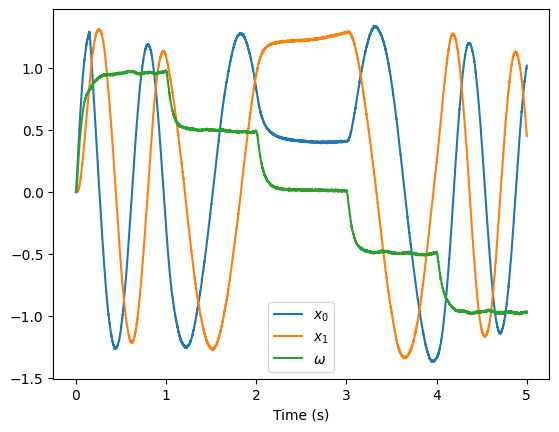

In [9]:
plt.figure()
plt.plot(sim.trange(), sim.data[oscillator_probe])
plt.xlabel("Time (s)")
plt.legend(["$x_0$", "$x_1$", r"$\omega$"])